## Spice and T section plots

Here we consider the spice variable. 

The version 2 finalizes the figures that will be put into the paper. 

The figures will include:  
a) Depth-along track distance (with time represented on 2nd axis) plot of temperature, with density overlaid.  
b) Mean-depth along track distance plot of spice.  
c) Marking the time on these panels will allow us to remove the sections from the plots with SSH. 
d) See if adding points to show dive locations helps to show sampling frequency. 


In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

In [17]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 16

In [3]:
ds_660_rho = xr.open_dataset('data/ctd_O2_660_isopycnal_grid_4m_22_sept_2021.nc')
ds_660_z   = xr.open_dataset('data/ctd_O2_660_vert_4m_binned_22_sept_2021.nc')

In [4]:
ds_660_rho

<xarray.Dataset>
Dimensions:       (rho_grid: 901, dives: 1007)
Coordinates:
  * rho_grid      (rho_grid) float64 27.0 27.0 27.0 27.0 ... 27.9 27.9 27.9 27.9
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    ctd_pressure  (rho_grid, dives) float64 ...
    CT            (rho_grid, dives) float64 ...
    SA            (rho_grid, dives) float64 ...
    Oxygen        (rho_grid, dives) float64 ...
    latitude      (rho_grid, dives) float64 ...
    longitude     (rho_grid, dives) float64 ...
    days          (rho_grid, dives) float64 ...

In [5]:
ds_660_z

<xarray.Dataset>
Dimensions:       (ctd_pressure: 250, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 2.0 6.0 10.0 14.0 ... 990.0 994.0 998.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    Oxygen        (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] ...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-09-22 10:40:49] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

#### Convert to along track distance axis from dives

In [6]:
from scipy import interpolate

In [7]:
def interp_distance(ds, var, vert_axis = 'ctd_pressure'): 

    #print (ds.longitude.mean(vert_axis))
    distance = np.cumsum(gt.utils.distance(ds.longitude.mean(vert_axis), 
                                           ds.latitude.mean(vert_axis)))
    
    #print(distance)
    dist_grid = np.arange(0, distance.max(), 500)

    for i in range(len(ds[vert_axis])): 
        
        #ds_temp = ds.isel(ctd_pressure=i) # would be nice if this was indexed without the hard coding
         
        #data = ds_temp[var].values
        
        ds_temp = ds[var][i,:]
        data = ds_temp.values
        
        f = interpolate.interp1d(distance, data, fill_value=np.nan)
        
        var_int = f(dist_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["distance"],
                                 coords={"distance": dist_grid, vert_axis: ds_temp[vert_axis]}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim=vert_axis)
        
    return da_var_int
            

In [8]:
# interpolate to dsistance axis
ds_660_z_dist = xr.merge( [interp_distance(ds_660_z.where(~np.isnan(ds_660_z.longitude.mean('ctd_pressure')), drop=True), 'CT'), 
                           interp_distance(ds_660_z.where(~np.isnan(ds_660_z.longitude.mean('ctd_pressure')), drop=True), 'SA'),
                           interp_distance(ds_660_z.where(~np.isnan(ds_660_z.longitude.mean('ctd_pressure')), drop=True), 'Oxygen'),
                           interp_distance(ds_660_z.where(~np.isnan(ds_660_z.longitude.mean('ctd_pressure')), drop=True), 'sigma0')] )

In [9]:
ds_660_rho_dist = xr.merge( [interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'CT', 'rho_grid'), 
                             interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'SA', 'rho_grid'), 
                             interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'Oxygen', 'rho_grid'), 
                             interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'ctd_pressure', 'rho_grid')] )

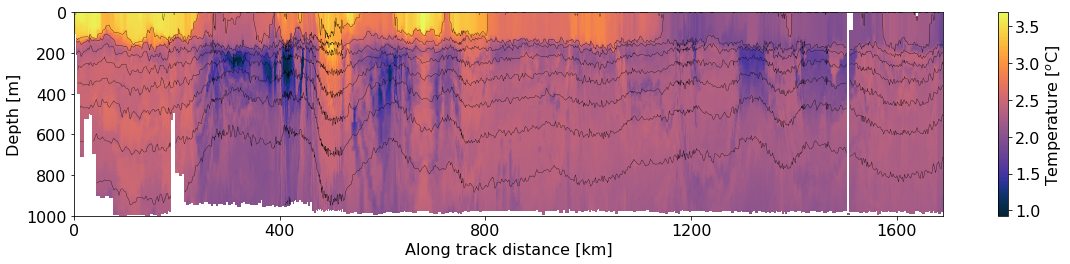

In [18]:
plt.figure(figsize=(2.2*7.5,2.2*1.8))
ds_660_z_dist.CT.plot(cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
ds_660_z_dist.sigma0.plot.contour(levels=np.linspace(27.0, 27.9,10), colors='k', linewidths=0.3)
plt.gca().invert_yaxis()

plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xlabel('Along track distance [km]')
plt.ylabel('Depth [m]')

plt.tight_layout()

plt.savefig('figures/figure_section_panel1.pdf')

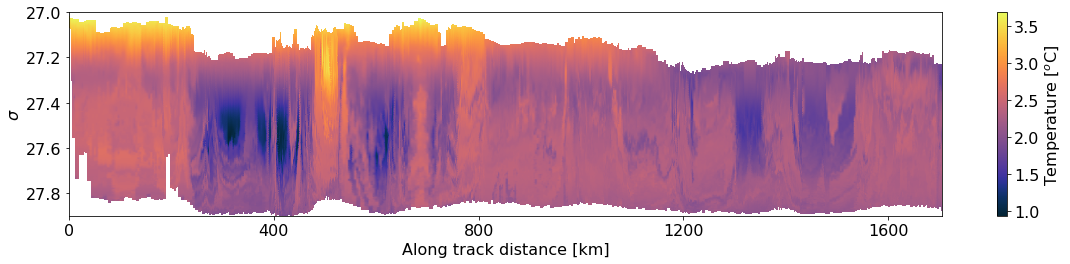

In [19]:
plt.figure(figsize=(2.2*7.5,2.2*1.8))

ds_660_rho_dist.CT.plot(cmap=cmo.thermal, rasterized=True, cbar_kwargs={'label': 'Temperature [$^o$C]'})
plt.gca().invert_yaxis()


plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xlabel('Along track distance [km]')
plt.ylabel('$\sigma$')

plt.tight_layout()
plt.savefig('figures/figure_section_panel2.pdf')

### Estimate the spice 

In [21]:
alpha = gsw.alpha(ds_660_rho_dist.SA, ds_660_rho_dist.CT, ds_660_rho_dist.ctd_pressure)

In [22]:
dCT = ds_660_rho_dist.CT - ds_660_rho_dist.CT.mean('distance')
spice = 2*1000*alpha*dCT

### Estimate the AOU

In [38]:
O2sol = gsw.O2sol(ds_660_rho_dist.SA, ds_660_rho_dist.CT, ds_660_rho_dist.ctd_pressure, 30+0.*ds_660_rho_dist.ctd_pressure, -52.5+0.*ds_660_rho_dist.ctd_pressure)

In [42]:
AOU = O2sol - ds_660_rho_dist.Oxygen

### Project from density to mean pressure 

In [24]:
Pmean_smooth = ds_660_rho_dist.ctd_pressure.mean('distance').rolling(rho_grid= 30, center=True).mean()

def func_var_int_pmean(ds): 
    Pmean_grid = np.linspace(0,1000,501)
    
    #ds = ds[var]
    
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean_smooth), drop=True)
    Pmean_nonan = Pmean_smooth.where(~np.isnan(ds) & ~np.isnan(Pmean_smooth), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'distance'],
                        coords = {'Pmean': Pmean_grid, 'distance': [ds.distance.values]})
    

In [44]:
# Interpolate to iso
distance_ind=0
spice_on_Pmean = func_var_int_pmean(spice.isel(distance=distance_ind))
oxygen_on_Pmean = func_var_int_pmean(ds_660_rho_dist.Oxygen.isel(distance=distance_ind))
AOU_on_Pmean = func_var_int_pmean(AOU.isel(distance=distance_ind))

for distance_ind in range(1, len(spice.distance)):
    if np.mod(distance_ind, 400)==0:
        print(distance_ind)
    spice_on_Pmean = xr.concat([spice_on_Pmean, func_var_int_pmean(spice.isel(distance=distance_ind))]
                              , dim='distance')
    oxygen_on_Pmean = xr.concat([oxygen_on_Pmean, func_var_int_pmean(ds_660_rho_dist.Oxygen.isel(distance=distance_ind))]
                              , dim='distance')
    AOU_on_Pmean = xr.concat([AOU_on_Pmean, func_var_int_pmean(AOU.isel(distance=distance_ind))]
                              , dim='distance')
    

400
800
1200
1600
2000
2400
2800
3200


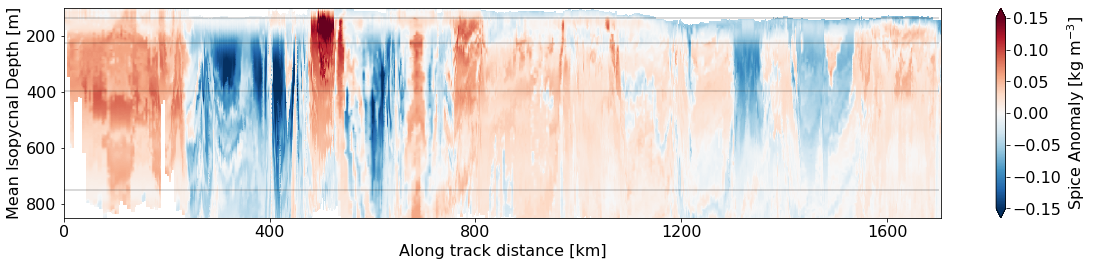

In [102]:
plt.figure(figsize=(2.2*7.5,2.2*1.8))
spice_on_Pmean.plot(vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.hlines(Pmean_smooth.sel(rho_grid=[27.2, 27.4, 27.6, 27.8], method='nearest').values,0, 1.7e6, 
          linewidths=0.3, colors='k')
plt.gca().invert_yaxis()


plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xlabel('Along track distance [km]')
plt.ylabel('Mean Isopycnal Depth [m]')
plt.ylim([850, 100])

plt.tight_layout()
plt.savefig('figures/figure_section_panel3.pdf')

In [49]:
# Respiration rate of about -0.05 umol kg^-1 day^-1

In [56]:
Age = AOU/0.1
Age_on_Pmean = AOU_on_Pmean/0.15

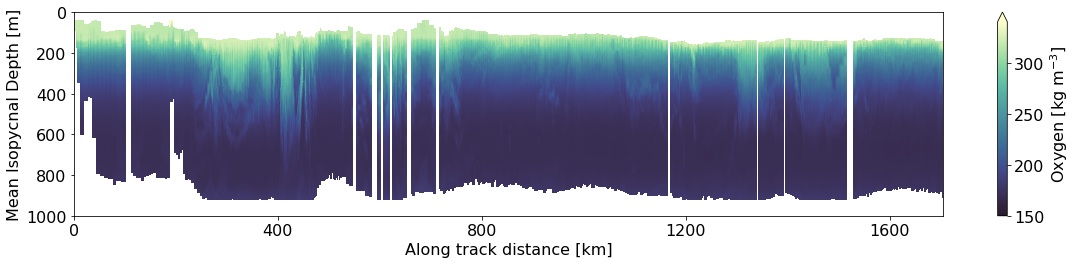

In [36]:
plt.figure(figsize=(2.2*7.5,2.2*1.8))
oxygen_on_Pmean.plot(vmin=150, vmax=340, rasterized=True, cmap=cmo.deep_r,#interpolation= None,
                           cbar_kwargs={'label': 'Oxygen [kg m$^{-3}$]'})
#plt.hlines(Pmean_smooth.sel(rho_grid=[27.2, 27.4, 27.6, 27.8], method='nearest').values,0, 1.7e6, 
#          linewidths=0.3, colors='k')
plt.gca().invert_yaxis()


plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xlabel('Along track distance [km]')
plt.ylabel('Mean Isopycnal Depth [m]')

plt.tight_layout()
#plt.savefig('figures/figure_section_panel4.pdf')

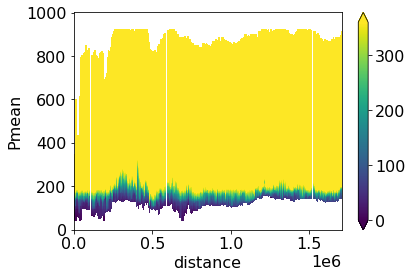

In [57]:
Age_on_Pmean.plot(vmin=0, vmax=360)

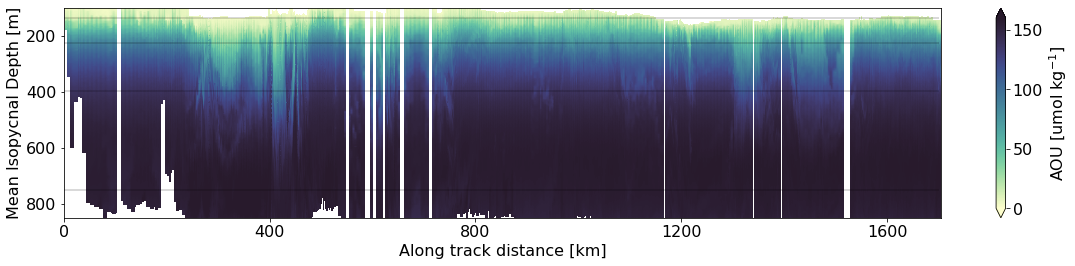

In [101]:
plt.figure(figsize=(2.2*7.5,2.2*1.8))
AOU_on_Pmean.plot(vmin=0, vmax=160, rasterized=True, cmap=cmo.deep,#interpolation= None,
                           cbar_kwargs={'label': 'AOU [umol kg$^{-1}$]'})
#AOU_on_Pmean.plot.contour(levels=[50, 80, 110], colors='k', linewidths=0.3,) #interpolation= None,
#                           cbar_kwargs={'label': 'AOU [umol kg$^{-1}$]'})
                         
plt.hlines(Pmean_smooth.sel(rho_grid=[27.2, 27.4, 27.6, 27.8], method='nearest').values,0, 1.7e6, 
          linewidths=0.3, colors='k')
plt.gca().invert_yaxis()


plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xlabel('Along track distance [km]')
plt.ylabel('Mean Isopycnal Depth [m]')

plt.ylim([850, 100])

plt.tight_layout()
plt.savefig('figures/figure_section_panel4.pdf')

### Layering

In [93]:
# the exact selection of these parameters here are based on the other notebook
i=30
spice_rho_rho = (spice.rolling(rho_grid=i, center=True).mean()).rolling(rho_grid=i, center=True).mean().diff('rho_grid').diff('rho_grid')/0.001/0.001

In [96]:
# Interpolate to iso
distance_ind=0
layering_on_Pmean = func_var_int_pmean(spice_rho_rho.isel(distance=distance_ind))

for distance_ind in range(1, len(spice.distance)):
    if np.mod(distance_ind, 400)==0:
        print(distance_ind)
    layering_on_Pmean = xr.concat([layering_on_Pmean, func_var_int_pmean(spice_rho_rho.isel(distance=distance_ind))]
                              , dim='distance')
    

400
800
1200
1600
2000
2400
2800
3200


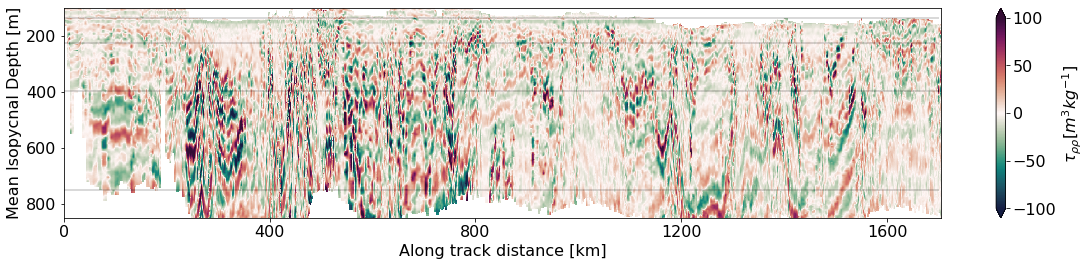

In [100]:
plt.figure(figsize=(2.2*7.5,2.2*1.8))
layering_on_Pmean.plot(vmin=-100, rasterized=True, cmap=cmo.curl,#interpolation= None,
                           cbar_kwargs={'label': r'$ \tau_{\rho \rho} [m ^3 kg ^{-1}]$'})
                         
plt.hlines(Pmean_smooth.sel(rho_grid=[27.2, 27.4, 27.6, 27.8], method='nearest').values,0, 1.7e6, 
          linewidths=0.3, colors='k')
plt.gca().invert_yaxis()


plt.xticks([0, 4e5, 8e5, 12e5, 16e5], labels=[0, 400, 800, 1200, 1600])
plt.xlabel('Along track distance [km]')
plt.ylabel('Mean Isopycnal Depth [m]')

plt.ylim([850, 100])

plt.tight_layout()
plt.savefig('figures/figure_section_panel5.pdf')

### Scraps

In [11]:
ds_660_z_dist

<xarray.Dataset>
Dimensions:       (distance: 3381, ctd_pressure: 250)
Coordinates:
  * distance      (distance) float64 0.0 500.0 1e+03 ... 1.69e+06 1.69e+06
  * ctd_pressure  (ctd_pressure) float64 2.0 6.0 10.0 14.0 ... 990.0 994.0 998.0
Data variables:
    CT            (ctd_pressure, distance) float64 3.602 nan nan ... nan nan nan
    SA            (ctd_pressure, distance) float64 34.15 nan nan ... nan nan nan
    sigma0        (ctd_pressure, distance) float64 27.02 nan nan ... nan nan nan

In [11]:
def interp_pres_dist(ds_glid, var, vert_axis='ctd_pressure'): 
    """ Return data variable interpolated onto a vertical axis-along track distance grid.
    
    Keyword argument.
    ds_glid -- dataset of the glider data
    var     -- variable that needs to be interpolated
    vert_axis -- variable with the name of the vertical axis
    """
    pres_ug = ds_glid[vert_axis]
    dist_ug = ds_glid.distance
    
    # convert to points values
    points = np.stack([dist_ug.values, pres_ug.values],axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(
                                    ~np.isnan(points[:,0]), 
                                    ~np.isnan(points[:,1])),
                             ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    # In the future this can be made into an input from the users    
    pres_grid = np.linspace(0,1000,251)
    dist_grid = np.arange(0, dist_ug.max().values, 3)
    grid_p, grid_d = np.meshgrid(pres_grid, dist_grid)
    
    temp_grided = griddata(points, 
                           values, 
                           (grid_d, grid_p), 
                           method='linear', 
                           rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                        dims=["pressure", "distance"],
                        coords={"pressure":pres_grid, "distance":dist_grid}
                       ).rename(var)

def convert_glider_dist_pres(ds_glid, vars_convert= ['temperature','salinity','potdens','spice']):
    """ Return a dataset gridded onto pressure vs along track distance grid.
    
    This is a helper function to apply gridding to multiple glider variables.
    """ 
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
        ds_grid[v] = interp_pres_dist(ds_glid, v)
        print('Gridded ' + v)
    
    return ds_grid

In [ ]:
ds_660_z_dist = convert_glider_dist_pres(ds_660_z, vars_convert=['CT'])

In [14]:
SA_lin = np.linspace(34.0, 35.1, 51)
CT_lin = np.linspace(0.5, 4, 51)

[SA_grid, CT_grid] = np.meshgrid(SA_lin, CT_lin)

rho_grid = gsw.sigma0(SA_grid, CT_grid)

Text(0, 0.5, 'CT')

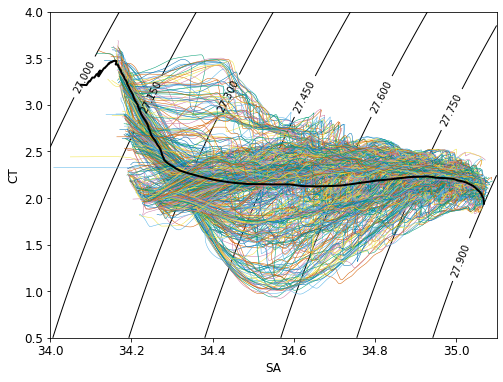

In [19]:
plt.figure(figsize=(8,6))
for i in range(0,1007,2):
    plt.plot(ds_660_rho.SA[:,i], ds_660_rho.CT[:,i], linewidth=0.5)
plt.plot(ds_660_rho.SA.mean('dives'),
         ds_660_rho.CT.mean('dives'), linewidth=2., color='k')

CS=plt.contour(SA_lin, CT_lin, rho_grid, linewidths=1, colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('SA')
plt.ylabel('CT')

In [22]:
rho0=1000
alpha_grid = gsw.alpha(SA_grid, CT_grid,50)*1e5
beta_grid  = gsw.beta(SA_grid, CT_grid,50)*1e5

<a list of 7 text.Text objects>

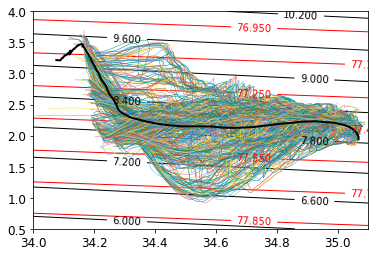

In [24]:
for i in range(0,1007,2):
    plt.plot(ds_660_rho.SA[:,i], ds_660_rho.CT[:,i], linewidth=0.5)
plt.plot(ds_660_rho.SA.mean('dives'),
         ds_660_rho.CT.mean('dives'), linewidth=2., color='k')

CS = plt.contour(SA_lin, CT_lin, alpha_grid, linewidths=1, colors='k')
plt.clabel(CS, inline=1, fontsize=10)

CS = plt.contour(SA_lin, CT_lin, beta_grid, linewidths=1, colors='r')
plt.clabel(CS, inline=1, fontsize=10)



In [25]:
# Pick constant alpha and beta for convenience (can always update later)
alpha = 8e-5
beta  = 77.4e-5

In [26]:
# remove a mean per isopycnal
dCT = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

In [151]:
spice1 = (2*alpha*dCT).rename('Spice')
spice2 = (2*beta*dSA).rename('Spice')
spice = (alpha*dCT + beta*dSA).rename('Spice')

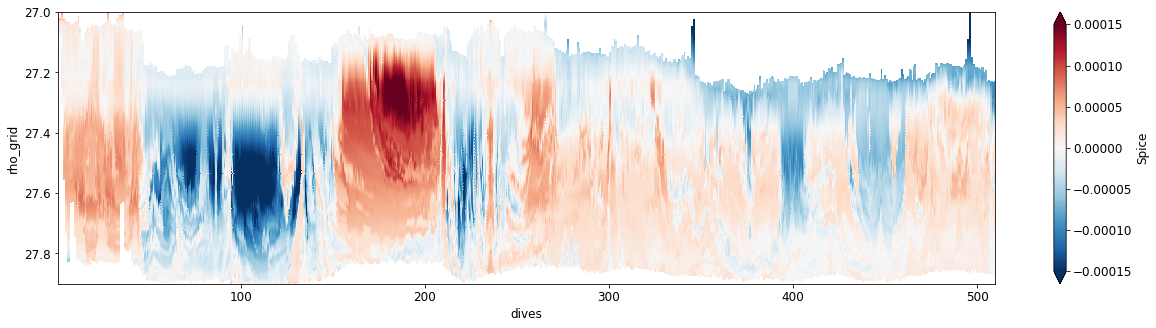

In [49]:
plt.figure(figsize=(21,5))
spice1.plot(vmin=-1.5e-4)
#plt.xlim([100,200])
plt.gca().invert_yaxis()

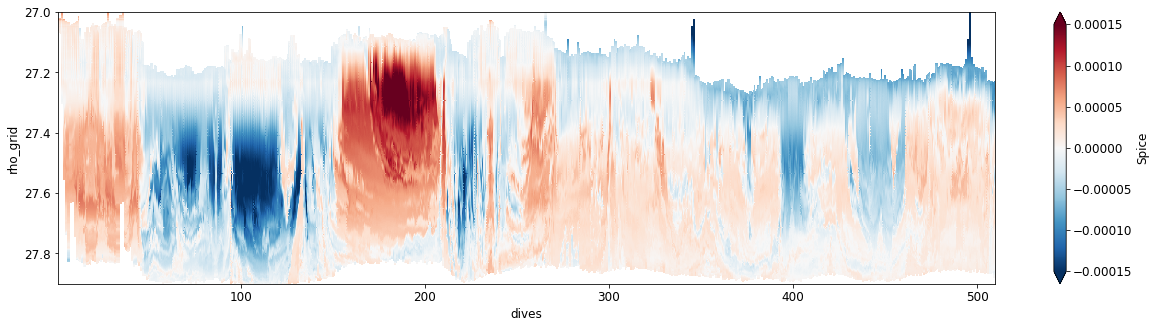

In [50]:
plt.figure(figsize=(21,5))
spice2.plot(vmin=-1.5e-4)
#plt.xlim([100,200])
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'The effect of choosing constant alpha and beta')

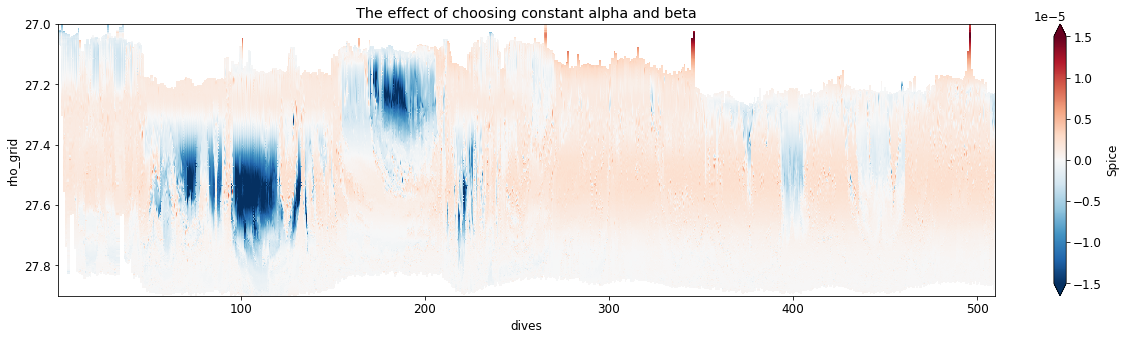

In [54]:
plt.figure(figsize=(21,5))
(spice1- spice2).plot(vmin=-1.5e-5)
#plt.xlim([100,200])
plt.gca().invert_yaxis()
plt.title('The effect of choosing constant alpha and beta')
# An order of magnitude smaller but might be important when looking at spectra

In [44]:
spice1.std().values, (spice1-spice2).std().values

(array(4.91165043e-05), array(2.81974092e-06))

In [ ]:
# Interpolate from the density only mean isopycnal depth for 

In [109]:
Pmean = ds_660_rho.ctd_pressure.mean('dives')
Pmean_smooth = ds_660_rho.ctd_pressure.mean('dives').rolling(rho_grid= 30, center=True).mean()
# do a little bit of smoothing. This is not a problem since all this is just for visualization. 

Text(0, 0.5, 'dPressure')

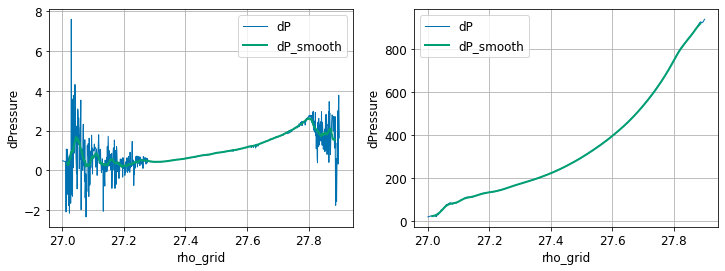

In [110]:
plt.figure(figsize=(12,4))
plt.subplot(121)
Pmean.diff('rho_grid').plot(linewidth=1, label='dP')
Pmean_smooth.diff('rho_grid').plot(linewidth=2, label='dP_smooth')

plt.grid()
plt.legend()
plt.ylabel('dPressure')

plt.subplot(122)
Pmean.plot(linewidth=1, label='dP')
Pmean_smooth.plot(linewidth=2, label='dP_smooth')

plt.grid()
plt.legend()
plt.ylabel('dPressure')

In [ ]:
from scipy import interpolate

In [126]:
def func_var_int_pmean(ds): 
    Pmean_grid = np.linspace(0,1000,501)
    
    #ds = ds[var]
    
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean_smooth), drop=True)
    Pmean_nonan = Pmean_smooth.where(~np.isnan(ds) & ~np.isnan(Pmean_smooth), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'dives'],
                        coords = {'Pmean': Pmean_grid, 'dives': [ds.dives.values]})
    

In [128]:
# Interpolate to iso
dive_ind=0
spice_on_Pmean = func_var_int_pmean(spice1.isel(dives=dive_ind))

for dive_ind in range(1, len(spice1.dives)):
    if np.mod(dive_ind, 100)==0:
        print(dive_ind)
    spice_on_Pmean = xr.concat([spice_on_Pmean, func_var_int_pmean(spice1.isel(dives=dive_ind))]
                              , dim='dives')
    

100
200
300
400
500
600
700
800
900
1000


In [136]:
spice_on_Pmean=spice_on_Pmean.rename('Spice')

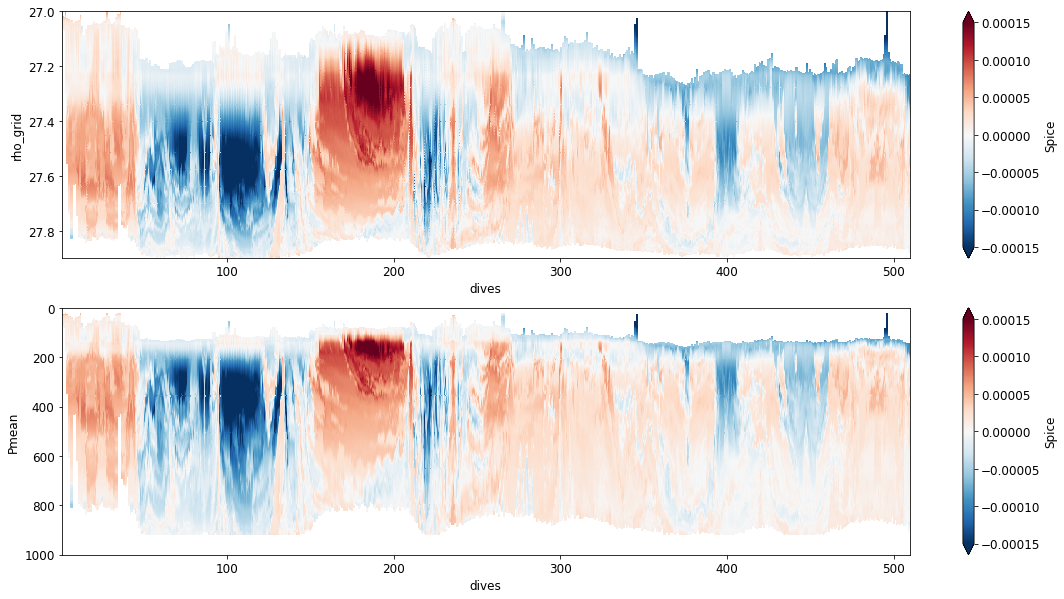

In [137]:
plt.figure(figsize=(19,10))

plt.subplot(211)
spice1.plot(vmin=-1.5e-4)
plt.gca().invert_yaxis()

plt.subplot(212)
spice_on_Pmean.plot(vmin=-1.5e-4)
plt.gca().invert_yaxis()

One of the amazing things here (in contrast to Jaeger et al or Klymak et al) is that there there is a lot of spice variance even at the deeper levels.

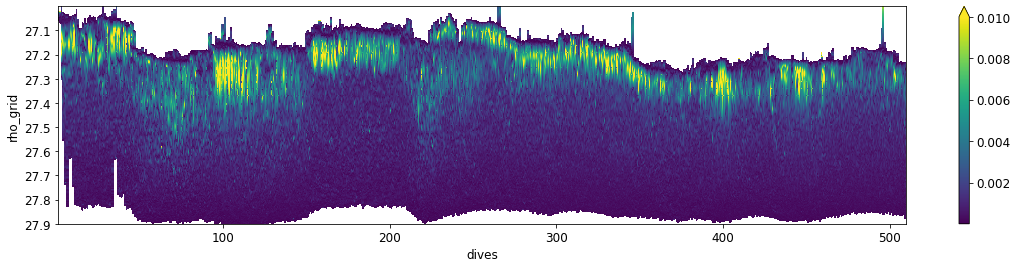

In [149]:
plt.figure(figsize=(19,4))
( ds_660_rho.rho_grid.diff('rho_grid')/ds_660_rho.ctd_pressure.diff('rho_grid') ).plot(vmax=1e-2)

plt.gca().invert_yaxis()